<br>
<div>
<center><font size = 8>  LDA  </font> <font size = 5 color = red >  VS   </font> <font size = 8>  QDA  </font> <font size = 5 color = red > VS  </font> <font size = 8> Logistic </font> </center>
</div>

![](./img/lda_qda.png)

## LDA
* $\hat\mu_k = \frac{1}{n_k}\sum_{i:y_i = k}x_i$
* $\hat\sigma^2 = \frac{1}{n-K}\sum_{k=1}^{K}\sum_{i:y_i = k}(x_i-\hat\mu_k)^2$
* $\hat\pi_k = \frac{n_k}{n}$
* $\delta_k(x) =  x^T\sum_k^{-1}\mu_k - \frac{1}{2}\mu_k^T\sum_k^{-1}\mu_k+ log(\pi_k)$

## QDA

* $\delta_k(x) = -\frac{1}{2}(x-\mu_k)^T\sum_k^{-1}(x-\mu_k) + log(\pi_k) - \frac{1}{2}|\sum_k|$ 

= -$\frac{1}{2}x^T\sum_k^{-1}x + x^T\sum_k^{-1}\mu_k - \frac{1}{2}\mu_k^T\sum_k^{-1}\mu_k+ log(\pi_k) - \frac{1}{2}|\sum_k|$

# Library Load

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from pycm import *
import warnings

warnings.filterwarnings('ignore')

## Data Load

In [2]:
DATA = pd.read_csv("./Default.csv")

In [3]:
logistic = LogisticRegression(random_state=5  ,class_weight  = "balanced" )

In [4]:
DATA.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [5]:
input_ = DATA[["balance", "income"]]
target = DATA[["default"]]

In [6]:
color = np.where( target["default"] == "No" , "blue" , "red")
target = np.where( target["default"] == "No" , 0.0 , 1.0 )

## Data Summary

In [7]:
a = DATA.groupby("default").agg(["mean", "var", "count"])
a

balance                             income                    
               mean            var count          mean           var count
default                                                                   
No        803.94375  208370.553613  9667  33566.166625  1.773758e+08  9667
Yes      1747.82169  116463.034541   333  32089.147124  1.905565e+08   333

In [8]:
mu_no = np.array([a["balance","mean"][0] , a["income","mean"][0]])
cov_no = DATA.loc[ DATA.default == "No", ["balance", "income"]].cov().values

##
mu_yes = np.array([a["balance","mean"][1] , a["income","mean"][1]])
cov_yes = DATA.loc[ DATA.default == "Yes", ["balance", "income"]].cov().values
cov = DATA[["balance", "income"]].cov().values

In [9]:
Prior = (DATA["default"].value_counts() /len(DATA))

In [10]:
cov_yes , cov_no , cov

(array([[ 1.16463035e+05, -7.80211173e+05],
        [-7.80211173e+05,  1.90556520e+08]]),
 array([[ 2.08370554e+05, -9.42750510e+05],
        [-9.42750510e+05,  1.77375816e+08]]),
 array([[ 2.33980187e+05, -9.82142336e+05],
        [-9.82142336e+05,  1.77865955e+08]]))

In [11]:
Count = DATA["default"].value_counts()

## LDA 

* Normal 가정과 Covariance Matrix가 Class별로 같다는 가정

$\sum_1 = \sum_2 = \sum = [\frac{n_1-1}{(n_1-1) + (n_2-1)}]\sum_1 + [\frac{n_2-1}{(n_1-1) + (n_2-1)}]\sum_2$

$f_k(x) = \frac{1}{\sqrt(2\pi)\sigma_k}exp(-\frac{1}{2\sigma_k^2(x-\mu_k)^2})$
$\sigma_1^2=\sigma_2^2=...=\sigma_k^2 :=\sigma^2$

In [12]:
# COV = Prior[Prior.index == "No"].values[0] * cov_no + \
# Prior[Prior.index == "Yes"].values[0] * cov_yes

COV =  ((Count[Count.index == "No"].values[0]-1) * cov_no +
        (Count[Count.index == "Yes"].values[0]-1) * cov_yes)  / (len(DATA)-2)


## Bayes Classifier  (LDA)

$\delta_k(x) = x^T \sum^{-1} \mu_k - \frac{1}{2}\mu_k^T\sum^{-1} \mu_k + log(\pi_k)$


In [13]:
def LDA_Bayes_Classifier( variable , cov , mu , prior , class_name) :
    if type(variable) == np.ndarray : 
        variable = variable
    else :
        variable = variable.values
    first = np.dot(np.dot(variable , np.linalg.inv(cov)) , mu) 
    second = 0.5 * np.dot(np.dot(np.transpose(mu) , np.linalg.inv(cov) ),mu)
    third = np.log(prior[prior.index == class_name].values[0])
    return first - second + third 

## Bayes Classifier  (QDA)

$\delta_k(x) = -\frac{1}{2}x^T\sum_k^{-1}x + x^T \sum^{-1} \mu_k - \frac{1}{2}\mu_k^T\sum^{-1} \mu_k + log(\pi_k) - \frac{1}{2}|\sum_k|$


In [14]:
def QDA_Bayes_Classifier(variable , cov , mu , prior , class_name) :
    if type(variable) == np.ndarray : 
        variable = variable
    else :
        variable = variable.values
    fir = np.dot(np.dot(variable , np.linalg.inv(cov)) , 
                 np.transpose(variable))
    fir = 0.5*np.diag(fir)
    sec = np.dot(np.dot(variable , np.linalg.inv(cov)) , mu) 
    thr = 0.5 * np.dot(np.dot(np.transpose(mu) , np.linalg.inv(cov) ),mu)
    fou = np.log(prior[prior.index == class_name].values[0])
    fiv = 0.5 * np.log( np.linalg.det(cov))
    return -fir + sec - thr + fou - fiv

In [15]:
no_lda_bayes  = LDA_Bayes_Classifier(input_ , COV , mu_no , Prior , "No")
yes_lda_bayes = LDA_Bayes_Classifier(input_ , COV , mu_yes , Prior , "Yes")

no_qda_bayes  = QDA_Bayes_Classifier(input_ , cov_no , mu_no , Prior , "No")
yes_qda_bayes = QDA_Bayes_Classifier(input_ , cov_yes , mu_yes , Prior , "Yes")


In [16]:
def likelihood(variable , cov , mu , prior , class_name) :
    if type(variable) == np.ndarray : 
        variable = variable
    else :
        variable = variable.values
    a = np.dot(np.dot(variable - mu ,  np.linalg.inv(cov)),
              np.transpose(variable - mu)) 
    a = np.exp(-0.5 * np.diag(a))
    nu = 1/(2*np.pi)**(np.shape(variable)[1]/2) * np.linalg.det(cov)**0.5
    return a/nu * prior[prior.index == class_name].values[0]
        

<div>
    <center><font size =7> LDA Probability   (same $\sigma$) </font></center>
    </div>

<br>
<br>

<div>
    <center><font size = 6>
    $p_k(x) = \frac{\pi_k \frac{1}{\sqrt(2\pi\sigma}exp(-\frac{1}{2\sigma^2}(x-\mu_k)^2)}{\sum_{l=1}^K\pi_l \frac{1}{\sqrt(2\pi\sigma}exp(-\frac{1}{2\sigma^2}(x-\mu_l)^2)}$
    </font><center>
</div>

In [17]:
yes_likeli = likelihood(input_ , COV , mu_yes , Prior , "Yes")
no_likeli = likelihood(input_ , COV , mu_no , Prior , "No")
p_yes_lda = yes_likeli / (yes_likeli + no_likeli)
p_no_lda = 1-p_yes_lda

<div>
    <center><font size =7> QDA Probability   (not same $\sigma$) </font></center>
    </div>

<br>
<br>

<div>
    <center><font size = 6>
    $p_k(x) = \frac{\pi_k \frac{1}{\sqrt(2\pi\sigma_k}exp(-\frac{1}{2\sigma_k^2}(x-\mu_k)^2)}{\sum_{l=1}^K\pi_l \frac{1}{\sqrt(2\pi\sigma_k}exp(-\frac{1}{2\sigma_k^2}(x-\mu_l)^2)}$
    </font><center>
</div>

In [18]:
yes_likeli = likelihood(input_ , cov_yes , mu_yes , Prior , "Yes")
no_likeli = likelihood(input_ , cov_no , mu_no , Prior , "No")
p_yes_qda = yes_likeli / (yes_likeli + no_likeli)
p_no_qda = 1-p_yes_qda

In [19]:
logistic.fit(input_.values , target)
logistic_p1 = logistic.predict_proba(input_.values )[:,1]

## 패키지를 활용한 모델 비교 (pycm)

In [20]:

lda_prediction = np.where(p_yes_lda > 0.6 , 1.0 , 0.0 )
qda_prediction = np.where(logistic_p1 > 0.6 , 1.0 , 0.0 )
logistic_prediction = np.where(p_yes_qda > 0.6 , 1.0 , 0.0 )
lda_cm = ConfusionMatrix(actual_vector=target, predict_vector=lda_prediction)
qda_cm = ConfusionMatrix(actual_vector=target, predict_vector=qda_prediction)
logistic_cm = ConfusionMatrix(actual_vector=target, predict_vector=logistic_prediction)

cp = Compare({"LDA":lda_cm,"QDA":qda_cm , "Logistic" :logistic_cm })
print(cp)

Best : QDA

Rank   Name        Class-Score   Overall-Score
1      QDA         3.6           1.48333
2      Logistic    2.9           1.48333
2      LDA         2.9           1.48333



## 패키지를 활용한 모델 통계량값 보기 (pycm)

In [21]:
qda_cm.relabel(mapping={0:"NO",1:"YES"})
print(qda_cm)

Predict    NO         YES        
Actual
NO         8667       1000       

YES        50         283        





Overall Statistics : 

95% CI                                                            (0.88899,0.90101)
AUNP                                                              0.8732
AUNU                                                              0.8732
Bennett S                                                         0.79
CBA                                                               0.55857
Chi-Squared                                                       1603.58319
Chi-Squared DF                                                    1
Conditional Entropy                                               0.48416
Cramer V                                                          0.40045
Cross Entropy                                                     0.29015
Gwet AC1                                                          0.87668
Hamming Loss                                  

In [22]:
LDA_Store = [[-100, 0, 0 ]]
QDA_Store =[[-100, 0, 0 ]]
Logistic_Store = [[-100, 0, 0 ]]
for i in np.linspace(0,1,num= 300) :
    lda_pred = np.where(p_yes_lda > i , 1 , 0)
    TP, FN, FP, TN  = confusion_matrix(target , lda_pred).ravel()
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    LDA_Store.append([i , FPR , TPR])
    qda_pred = np.where(p_yes_qda > i , 1 , 0)
    TP, FN, FP, TN  = confusion_matrix(target , qda_pred).ravel()
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    QDA_Store.append([i , FPR , TPR])
    log_pred = np.where(logistic_p1 > i , 1 , 0)
    TP, FN, FP, TN  = confusion_matrix(target , log_pred).ravel()
    FPR = FP / (FP + TN)
    TPR = TP / (TP + FN)
    Logistic_Store.append([i , FPR , TPR])
    
    
LDA_Store.append([100 , 1.0 , 1.0])
QDA_Store.append([100 , 1.0 , 1.0])
Logistic_Store.append([100 , 1.0 , 1.0])

<br>
<div>
    <center>
    <font size = 6> Confusion Matrix Table </font></center>
    </div>

<br>
<center>
    <img src = "./img/confusionmatrix.png">
</center>

In [23]:
LDA_Output = pd.DataFrame(LDA_Store)
LDA_Output.columns = ["cutoff", "FPR", "TPR"]
LDA_Output = LDA_Output.dropna()
LDA_Output.sort_values("FPR" , inplace=True)

In [24]:
QDA_Output = pd.DataFrame(QDA_Store)
QDA_Output.columns = ["cutoff", "FPR", "TPR"]
QDA_Output = QDA_Output.dropna()
QDA_Output.sort_values("FPR" , inplace=True)

In [25]:
Logistic_Output = pd.DataFrame(Logistic_Store)
Logistic_Output.columns = ["cutoff", "FPR", "TPR"]
Logistic_Output = Logistic_Output.dropna()
Logistic_Output.sort_values("FPR" , inplace=True)

In [26]:
Logistic_Output.cutoff = Logistic_Output.cutoff.round(4)
QDA_Output.cutoff = QDA_Output.cutoff.round(4)
LDA_Output.cutoff = LDA_Output.cutoff.round(4)

## 특정 Cutoff에서 보기 [0.4983 ~ 0.5686]

In [27]:
logic_cut = Logistic_Output[Logistic_Output.cutoff.isin([0.4983 , 0.5686])] 
qda_cut   = QDA_Output[QDA_Output.cutoff.isin([0.4983 , 0.5686])] 
lda_cut   = LDA_Output[LDA_Output.cutoff.isin([0.4983 , 0.5686])] 

In [28]:
a = {'type': 'line','x0': logic_cut.FPR.values[0] ,'y0': 0,'x1': logic_cut.FPR.values[0],'y1': logic_cut.TPR.values[0],
     'line': {'color': 'blue','width': 3,}}
b = {'type': 'line','x0': logic_cut.FPR.values[1] ,'y0': 0,'x1': logic_cut.FPR.values[1],'y1': logic_cut.TPR.values[1],
     'line': {'color': 'blue','width': 3,}}
c = {'type': 'line','x0': qda_cut.FPR.values[0] ,'y0': 0,'x1': qda_cut.FPR.values[0],'y1': qda_cut.TPR.values[0],
     'line': {'color': 'red','width': 3,}}
d = {'type': 'line','x0': qda_cut.FPR.values[1] ,'y0': 0,'x1': qda_cut.FPR.values[1],'y1': qda_cut.TPR.values[1],
     'line': {'color': 'red','width': 3,}}
e = {'type': 'line','x0': lda_cut.FPR.values[0] ,'y0': 0,'x1': lda_cut.FPR.values[0],'y1': lda_cut.TPR.values[0],
     'line': {'color': 'green','width': 3,}}
f = {'type': 'line','x0': lda_cut.FPR.values[1] ,'y0': 0,'x1': lda_cut.FPR.values[1],'y1': lda_cut.TPR.values[1],
     'line': {'color': 'green','width': 3,}}

## ROC CURVE Visualization

In [29]:

trace = go.Scatter(
    x = np.array(LDA_Output)[:,1],
    y = np.array(LDA_Output)[:,2],
    mode = 'lines+markers',
    text= ["Cut off : {:.3f}".format(i) for i in np.array(LDA_Output)[:,0].tolist()] ,
    textposition='top right',
    marker = dict(color = "green",
                 line = dict(color = "green")) , 
    name ='LDA',
)
trace2 = go.Scatter(
    x = np.array(QDA_Output)[:,1],
    y = np.array(QDA_Output)[:,2],
    mode = 'lines+markers',
    name ='QDA',
    textposition='bottom left' , 
    marker = dict(color = "red",
                 line = dict(color = "red")) ,
    text= ["Cut off : {:.3f}".format(i) for i in np.array(QDA_Output)[:,0].tolist()] , 
)
trace3 = go.Scatter(
    x = np.array(Logistic_Output)[:,1],
    y = np.array(Logistic_Output)[:,2],
    mode = 'lines+markers',
    name ='Logistic',
    marker = dict(color = "blue" ,
                 line = dict(color = "blue")) ,
    text= ["Cut off : {:.3f}".format(i) for i in np.array(Logistic_Output)[:,0].tolist()] , 
)
trace_line = go.Scatter(
    x= [0,1],
    y= [0,1],
    name = "" , 
    marker = dict(color = "black") ,
    mode ='lines'
)
data = [trace , trace2 , trace3 , trace_line]

layout = dict(title = 'ROC Curve (LDA, QDA , Logistic)',
              xaxis = dict(title = 'FPR(1-Specificity)'),
              yaxis = dict(title = 'TPR(Sensitivity)'),
              width=700,
              height=700,
              shapes = [a,b,c,d,e,f]
              )

fig = dict(data=data, layout=layout)
iplot(fig, filename='basic-line')

## Figure 4.7 Threshold 에 따른 Error Visualization

In [30]:
LDA_Store = []
QDA_Store =[]
Logistic_Store = []

for i in np.linspace(0.0, 0.5,num= 30) :
    lda_pred = np.where(p_yes_lda > i , 1 , 0)
    TP, FN, FP, TN  = confusion_matrix(target , lda_pred).ravel()
    one_sensitivity = FP / (TN + FP)
    Error = (FN + FP )/(TP + FN + FP + TN)
    LDA_Store.append([i , one_sensitivity , Error])
    qda_pred = np.where(p_yes_qda > i , 1 , 0)
    TP, FN, FP, TN  = confusion_matrix(target , qda_pred).ravel()
    one_sensitivity = FP / (TN + FP)
    Error = (FN + FP )/(TP + FN + FP + TN)
    QDA_Store.append([i , one_sensitivity , Error])
    log_pred = np.where(logistic_p1 > i , 1 , 0)
    TP, FN, FP, TN  = confusion_matrix(target , log_pred).ravel()
    one_sensitivity = FP / (TN + FP)
    Error = (FN + FP )/(TP + FN + FP + TN)
    Logistic_Store.append([i , one_sensitivity , Error])


In [31]:
trace = go.Scatter(
    x = np.array(LDA_Store)[:,0],
    y = np.array(LDA_Store)[:,1],
    mode = 'lines+markers',
    name ='LDA',
)
trace2 = go.Scatter(
    x = np.array(QDA_Store)[:,0],
    y = np.array(QDA_Store)[:,1],
    mode = 'lines+markers',
    name ='QDA',
)
trace3 = go.Scatter(
    x = np.array(Logistic_Store)[:,0],
    y = np.array(Logistic_Store)[:,1],
    mode = 'lines+markers',
    name = "Logistic"
)

trace4 = go.Scatter(
    x = np.array(LDA_Store)[:,0],
    y = np.array(LDA_Store)[:,2],
    mode = 'lines+markers',
    name ='LDA Error',
)
trace5 = go.Scatter(
    x = np.array(QDA_Store)[:,0],
    y = np.array(QDA_Store)[:,2],
    mode = 'lines+markers',
    name ='QDA Error',
)
trace6 = go.Scatter(
    x = np.array(Logistic_Store)[:,0],
    y = np.array(Logistic_Store)[:,2],
    mode = 'lines+markers',
    name = "Logistic Error"
)

data = [trace , trace2 , trace3 , trace4 , trace5 , trace6]

layout = dict(title = 'Error Visualization (LDA, QDA , Logistic)',
              xaxis = dict(title = 'Threshold'),
              yaxis = dict(title = 'Error Rate'),
              width=700,
              height=700,
              )

fig = dict(data=data, layout=layout)
iplot(fig, filename='basic-line')

## Grid 설정 및 Logistic Fitting

In [32]:
grid_n = 200
x_min, x_max = input_.values[:,0].min() - .01, input_.values[:,0].max() + .01
y_min, y_max = input_.values[:,1].min() - .01, input_.values[:,1].max() + .01
x = np.linspace(x_min , x_max , num = grid_n)
y = np.linspace(y_min, y_max  , num = grid_n)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
logistic.fit(input_.values , target)
D = logistic.decision_function(XX)
D = D.reshape(X.shape)

## Logisitc에 따른 Decision Boundary 시각화

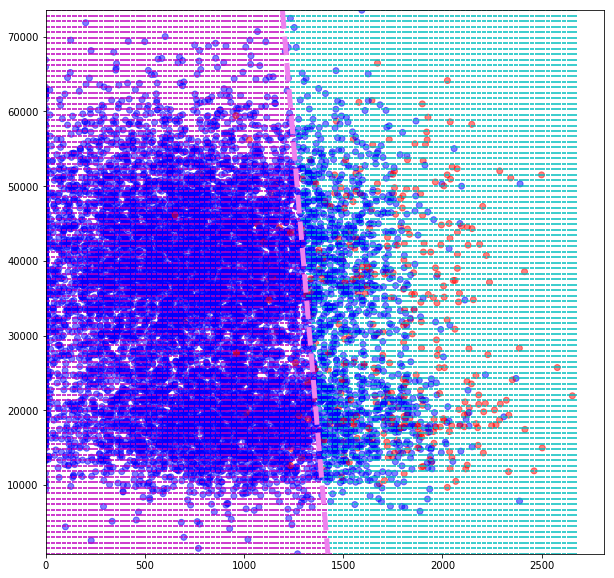

In [33]:
fig = plt.figure(figsize=(10,10))
plt.scatter(input_["balance"].values , input_["income"].values , c = color , alpha= 0.5) ; 
x = np.linspace(x_min , x_max , num = 100)
y = np.linspace(y_min, y_max  , num = 100)
x, y = np.meshgrid(x , y )
xx = np.array([x.ravel(), y.ravel()]).T
grid_D = logistic.decision_function(xx)
grid_class = np.where(grid_D > 0 , "c","m")
plt.scatter(x,y, s=20, c= grid_class, marker = 1)
plt.contour(X , Y ,  D  , colors='violet' , linestyles  ="dashed" , linewidths  = 5 , levels = [0.0] )
plt.show()

## `LDA`에 따른 Decision Boundary
* `Logistic` Decision Boundary도 같이 시각화

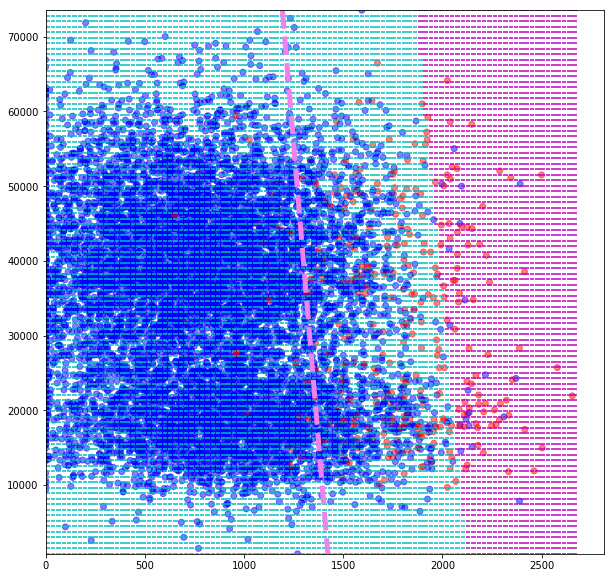

In [34]:
fig = plt.figure(figsize=(10,10))
plt.scatter(input_["balance"].values , input_["income"].values , c = color , alpha= 0.5) ; 
x = np.linspace(x_min , x_max , num = 100)
y = np.linspace(y_min, y_max  , num = 100)
x, y = np.meshgrid(x , y )
xx = np.array([x.ravel(), y.ravel()]).T
no_lda_bayes  = LDA_Bayes_Classifier(xx , COV , mu_no , Prior , "No")
yes_lda_bayes = LDA_Bayes_Classifier(xx , COV , mu_yes , Prior , "Yes")
lda_class = np.where(no_lda_bayes > yes_lda_bayes , "c","m")

plt.scatter(x,y, s=20, c= lda_class, marker = 1)
plt.contour(X , Y ,  D  , colors='violet' , linestyles  ="dashed" , linewidths  = 5 , levels = [0.0] )
plt.show()

# LDA, QDA , Logistic Decision Boundary Visualization

* Grid `QDA` 기준

In [35]:
no_lda_bayes  = LDA_Bayes_Classifier(XX , COV , mu_no , Prior , "No")
yes_lda_bayes = LDA_Bayes_Classifier(XX , COV , mu_yes , Prior , "Yes")
lda_tour = np.where(no_lda_bayes - yes_lda_bayes > 0 , 1 , 0 ).reshape(X.shape)
no_qda_bayes  = QDA_Bayes_Classifier(XX , cov_no , mu_no , Prior , "No")
yes_qda_bayes = QDA_Bayes_Classifier(XX , cov_yes , mu_yes , Prior , "Yes")
qda_tour = np.where(no_qda_bayes - yes_qda_bayes > 0 , 1 , 0 ).reshape(X.shape)

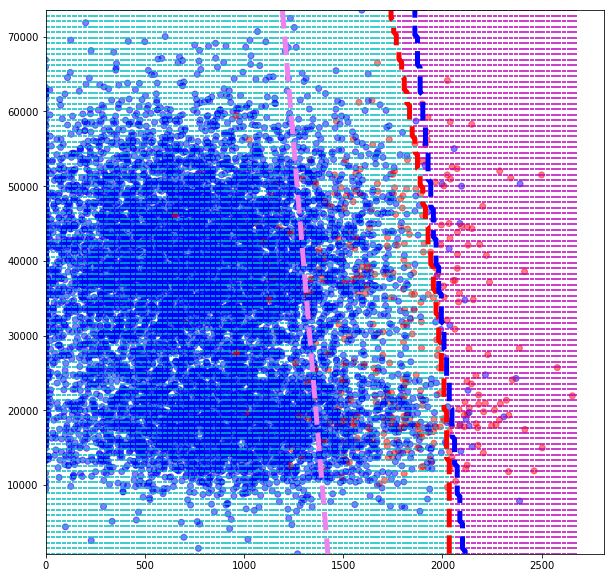

In [36]:
fig = plt.figure(figsize=(10,10))
plt.scatter(input_["balance"].values , input_["income"].values , c = color , alpha= 0.5) ; 
x = np.linspace(x_min , x_max , num = 100)
y = np.linspace(y_min, y_max  , num = 100)
x, y = np.meshgrid(x , y )
xx = np.array([x.ravel(), y.ravel()]).T
no_qda_bayes  = QDA_Bayes_Classifier(xx , cov_no , mu_no , Prior , "No")
yes_qda_bayes = QDA_Bayes_Classifier(xx , cov_yes , mu_yes , Prior , "Yes")
qda_class = np.where(no_qda_bayes > yes_qda_bayes , "c","m")

plt.scatter(x,y, s=20, c= qda_class, marker = 1)
plt.contour(X , Y ,  D  , colors='violet' , linestyles  ="dashed" , linewidths  = 5 , levels = [0.0] )
plt.contour(X , Y ,  qda_tour  , colors='red' , linestyles  ="dashed" , linewidths  = 5 , levels = [0.5] )
plt.contour(X , Y ,  lda_tour  , colors='blue' , linestyles  ="dashed" , linewidths  = 5 , levels = [0.5] )
plt.show()

## 6 Scenarios

1. $\mu_1 = {-1 \choose -1} , \mu_2 = {1 \choose 1}$  ,  $cov = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$ ,  $N(\mu_k , \sum) \quad $  $k = (1,2)$

2.  $\mu_1 = {-1 \choose -1} , \mu_2 = {1 \choose 1}$  ,  $cov = \begin{pmatrix} 1 & -0.5 \\ -0.5 & 1 \end{pmatrix}$ ,  $N(\mu_k , \sum) \quad $  $k = (1,2)$

3. $x_{i1} , x_{i2} \sim t(15) \quad $  ${-1 \choose -1} + {x_{i1} \choose x_{i2}}_{i=1,...,50} \quad $ ${1 \choose 1} + {x_{i1} \choose x_{i2}}_{i=51,...,100}$ 

4. $\mu_1 = {-1 \choose -1} , \mu_2 = {1 \choose 1}$  ,  $cov_1 = \begin{pmatrix} 1 & -0.5 \\ -0.5 & 1 \end{pmatrix} \quad$ ,   $cov_2 = \begin{pmatrix} 1 & 0.5 \\ 0.5 & 1 \end{pmatrix}$ ,  $N(\mu_k , \sum_k)_{k=1,2} \quad $ 

5. $x_1 \sim N(0,1) \quad x_2 \sim N(0,1) \quad P(x_i) = \frac{1}{1+ exp(+x_{1i}^2-x_{2i}^2 + x_1x_2)} \quad y_i \sim Ber(1, P(x_i))$

6. $x_1 \sim N(0,1) \quad x_2 \sim N(0,1) \quad P(x_i) = \frac{1}{1+ exp(+sin(x_{1i})+ \frac{1}{2}sin(\frac{1}{2}x_1 x_2) + x_2)} \quad y_i \sim Ber(1, P(x_i))$

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA_m
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA_m
from sklearn.linear_model import LogisticRegression as LR_m
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import seaborn as sns

from scipy.stats import bernoulli
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [65]:
mean_1 , cov_1 = [-1,-1]  , [[1,0],[0,1]]
mean_2 , cov_2 = [1,1]  , [[1,0],[0,1]]

def error_print(f , test_input , test_target) :
    error = 1 - sum(f.predict(test_input) == test_target) / len(test_target)
    return error

def Scenario_collection(number=1 , size_n = None, mean_1 = mean_1,mean_2 = mean_2 ,
             cov_1 = cov_1 , cov_2 = cov_2 , t = 2) :
    if number in [1,2,4] :
        x1     = np.random.multivariate_normal(mean = mean_1, 
                                               cov  = cov_1, size = size_n)
        x2     = np.random.multivariate_normal(mean = mean_2, 
                                               cov  = cov_2, size = size_n)
        Input  = np.concatenate((x1,x2), axis = 0)
        target = [1]*size_n + [0]*size_n
    elif number in [3] :
        x1     = np.random.standard_t(t , size=(size_n,2)) + [-0.5,-0.5]
        x2     = np.random.standard_t(t , size=(size_n,2)) + [0.5,0.5]
        Input  = np.concatenate((x1,x2), axis = 0)
        target = [1] * size_n + [0] * size_n
    elif number in [5] :
        x1    = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x2    = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x1x2  = np.multiply(x1 ,x2)[:,np.newaxis]
        x1_2  = np.square(x1)[:,np.newaxis]
        x2_2  = np.square(x2)[:,np.newaxis]
        Input = np.hstack((x1_2, x1x2 , x2_2))
        p     =  1/(1+np.exp(+10*x1_2 - 10*x2_2 + x1x2))
        target = []
        for i in np.squeeze(p).tolist() :
            r = bernoulli.rvs(p = i , size= 1)[0]
            target.append(r)
    elif number in [6] :
        x1   = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x2   = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
        x1x2 = np.multiply(x1 ,x2)
        p    = 1/(1+np.exp((-np.sin(x1) +0.5*np.sin(2*x1x2) - x2)))
        target = []
        for i in np.squeeze(p).tolist() :
            r = bernoulli.rvs(p = i , size= 1)[0]
            target.append(r)
        x1    = x1[:,np.newaxis]
        x2    = x2[:,np.newaxis]
        x1x2  = x1x2[:,np.newaxis]
        Input = np.hstack((x1, x1x2 , x2))
    return Input , target

def compute(Scenario , number) :
    cv_scores = []
    Input , target = Scenario(number = number , size_n = 50)
    # perform 5-fold cross validation
    for k in np.arange(1,20) :
        knn    = KNN(n_neighbors=k)
        scores = cross_val_score(knn, Input, target, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())

    print("Cross Validation Optimal K : {}".format(np.arange(1,20)[np.argmax(cv_scores)]))
    LDA    = LDA_m()
    QDA    = QDA_m()
    LR     = LR_m()
    knn_cv = KNN(n_neighbors = np.arange(1,20)[np.argmax(cv_scores)])
    knn_1  = KNN(n_neighbors = 1)

    knn_1_error  = []
    knn_cv_error = []
    lda_error    = []
    qda_error    = []
    lr_error     = []
    
    for _ in np.arange(100) :
        ## Data Generate
        train_input , train_target = Scenario(number = number , size_n = 100)
        test_input , test_target   = Scenario(number = number , size_n = 5000)
        ## Model Fitting
        LDA.fit(train_input , train_target)
        QDA.fit(train_input , train_target)
        LR.fit(train_input , train_target)
        knn_1.fit(train_input , train_target)
        knn_cv.fit(train_input , train_target)
        ## Predict
        error = error_print(knn_1 , test_input , test_target)
        knn_1_error.append(error)
        error = error_print(knn_cv , test_input , test_target)
        knn_cv_error.append(error)
        error = error_print(LDA , test_input , test_target)
        lda_error.append(error)
        error = error_print(QDA , test_input , test_target)
        qda_error.append(error)
        error = error_print(LR , test_input , test_target)
        lr_error.append(error)
        
    return knn_1_error , knn_cv_error , lda_error , qda_error , lr_error

def vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error) :
    error_store     = [knn_1_error + 
                       knn_cv_error + 
                       lda_error + 
                       qda_error + 
                       lr_error]
    name_store      = [["knn-1"]*100 + 
                       ["knn-cv"]*100 + 
                       ["LDA"]*100 + 
                       ["QDA"]*100 + 
                       ["Logistic"]*100]
    output          = pd.DataFrame(error_store + name_store).T
    output.columns  = ["error", "name"]
    output["error"] = output["error"].astype(float)
    sns.boxplot(x="name", y="error", data=output).set_title("SCENARIO");

In [461]:
def Scenario_1_2_4(size_n, mean_1 =mean_1, mean_2=mean_2 , cov_1=cov_1 , cov_2 = cov_2) :
    x1 = np.random.multivariate_normal(mean = mean_1, 
                                       cov  = cov_1, size = size_n)
    x2 = np.random.multivariate_normal(mean = mean_2, 
                                       cov  = cov_2, size = size_n)
    Input = np.concatenate((x1,x2), axis = 0)
    target = [1]*size_n + [0]*size_n
    return Input , target

def Scenario_3(size_n , t = 15) :
    x1 = np.random.standard_t(t , size=(size_n,2)) + [-1,-1]
    x2 = np.random.standard_t(t , size=(size_n,2)) + [1,1]
    total = np.concatenate((x1,x2), axis = 0)
    target = [1] * size_n + [0] * size_n
    return total , target

def Scenario_5(size_n) :
    x1 = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
    x2 = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
    x1x2 = np.multiply(x1 ,x2)[:,np.newaxis]
    x1_2 = np.square(x1)[:,np.newaxis]
    x2_2 = np.square(x2)[:,np.newaxis]
    Input = np.hstack((x1_2, x1x2 , x2_2))
    p =  1/(1+np.exp(-x1_2 -x2_2 + x1x2))
    target = []
    for i in np.squeeze(p).tolist() :
        r = bernoulli.rvs(p = i , size= 1)[0]
        target.append(r)
    return Input , target

def Scenario_6(size_n) :
    x1 = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
    x2 = np.random.normal(loc= 0 , scale=1 , size=(size_n,))
    x1x2 = np.multiply(x1 ,x2)
    p =  1/(1+np.exp(-(np.sin(x1) +0.5*np.sin(0.5*x1x2) + x2)))
    target = []
    for i in np.squeeze(p).tolist() :
        r = bernoulli.rvs(p = i , size= 1)[0]
        target.append(r)
    x1 = x1[:,np.newaxis]
    x2 = x2[:,np.newaxis]
    x1x2 = x1x2[:,np.newaxis]
    Input = np.hstack((x1, x1x2 , x2))
    return Input , target

## Scenario 1

Cross Validation Optimal K : 5


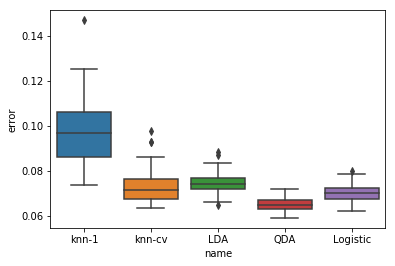

In [462]:
mean_1 , cov_1 = [-1,-1]  , [[1,0],[0,1]]
mean_2 , cov_2 = [1,1]  , [[1,0],[0,1]]
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error =\
compute(Scenario_collection , 1)
vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error)

## Scenario 2

Cross Validation Optimal K : 14


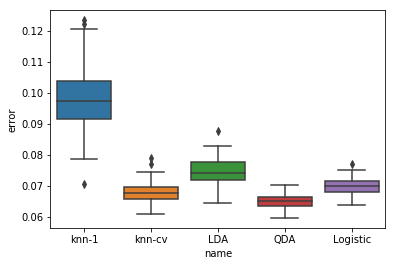

In [463]:
mean_1 , cov_1 = [-1,-1]  , [[1,-0.5],[-0.5,1]]
mean_2 , cov_2 = [1,1]  , [[1,-0.5],[-0.5,1]]
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error =\
compute(Scenario_collection , 2)
vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error)

## Scenario 3

Cross Validation Optimal K : 9


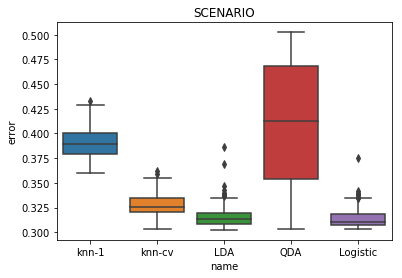

In [56]:
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 3)
vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error)

## Scenario 4

Cross Validation Optimal K : 3


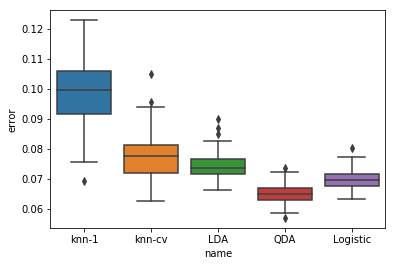

In [465]:
mean_1 , cov_1 = [-1,-1]  , [[1,-0.5],[-0.5,1]]
mean_2 , cov_2 = [1,1]  , [[1,0.5],[0.5,1]]
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 4)
vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error)

## Scenario 5

Cross Validation Optimal K : 12


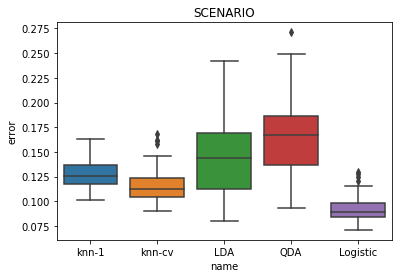

In [60]:
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 5)
vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error)

## Scenario 6

In [ ]:
knn_1_error,knn_cv_error,lda_error,qda_error,lr_error = \
compute(Scenario_collection , 6)
vis(knn_1_error,knn_cv_error,lda_error,qda_error,lr_error)

Cross Validation Optimal K : 6


## 참고

### [LDA 설명 자료1](https://www.datascienceblog.net/post/machine-learning/linear-discriminant-analysis/)

### [LDA,QDA 설명 자료2](https://yintingchou.com/posts/lda-and-qda/)

### [시각화 참고 자료](https://datascienceschool.net/view-notebook/2c6a8e003219446995f3d866ac8a6fd1/)

